![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

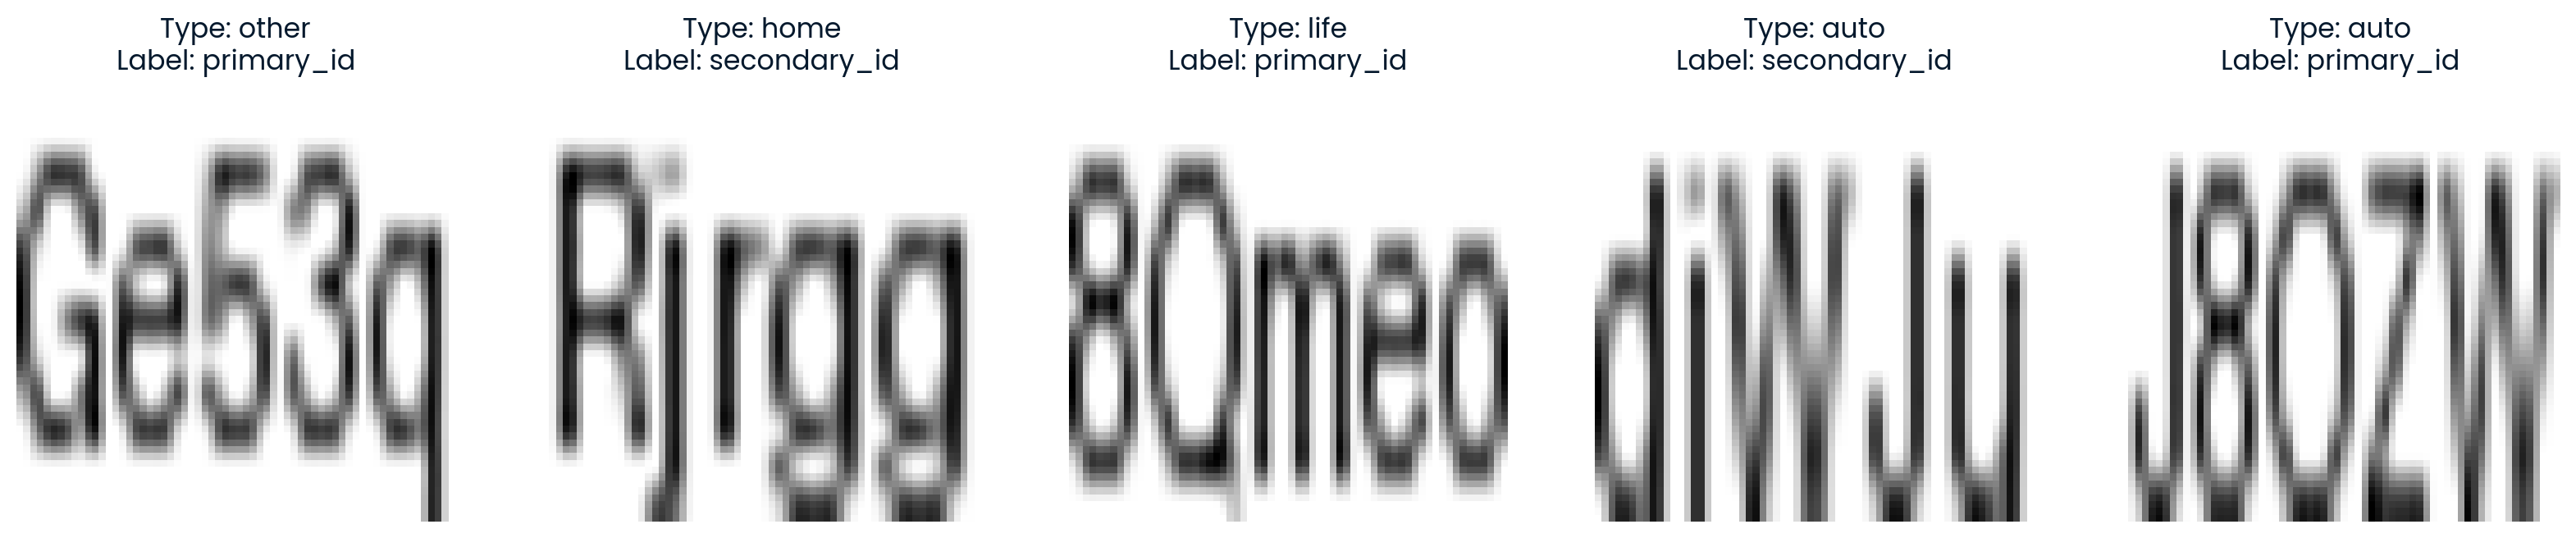

In [12]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [13]:
# OCRModel
class OCRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, 128)
        )
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128+10, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  
        )
        
    def forward(self, x_image, x_type):
        image_layer = self.image_layer(x_image)
        type_layer = self.type_layer(x_type)
        x = torch.cat( (image_layer, type_layer), dim=1 )
        return self.classifier(x)   
    
model = OCRModel()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

dataloader_train = DataLoader(
    dataset, shuffle=True, batch_size=10,
)

for epoch in range(10):
    for (features, types), labels in dataloader_train:
        optimiser.zero_grad()
        outputs = model(features, types)
        loss = criterion(outputs , labels)
        loss.backward()
        optimiser.step()
        
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.7036328911781311
Epoch 2, Loss: 0.6684044003486633
Epoch 3, Loss: 0.6586177945137024
Epoch 4, Loss: 1.1637989282608032
Epoch 5, Loss: 0.5534274578094482
Epoch 6, Loss: 0.513412356376648
Epoch 7, Loss: 0.3718150854110718
Epoch 8, Loss: 0.18420784175395966
Epoch 9, Loss: 0.12657621502876282
Epoch 10, Loss: 0.1568930596113205
Epoch 11, Loss: 0.10762818902730942
Epoch 12, Loss: 0.05289585515856743
Epoch 13, Loss: 0.005607927683740854
Epoch 14, Loss: 0.008113570511341095
Epoch 15, Loss: 0.0033661327324807644
Epoch 16, Loss: 0.0010870893020182848
Epoch 17, Loss: 0.00025198221555911005
Epoch 18, Loss: 0.00042726699030026793
Epoch 19, Loss: 0.000289615971269086
Epoch 20, Loss: 6.27789122518152e-05
Epoch 21, Loss: 1.4447784451476764e-05
Epoch 22, Loss: 4.7681671276222914e-05
Epoch 23, Loss: 4.746532067656517e-05
Epoch 24, Loss: 3.0015220545465127e-05
Epoch 25, Loss: 2.5247642042813823e-05
Epoch 26, Loss: 1.8345996068092063e-05
Epoch 27, Loss: 1.565157072036527e-05
Epoch 28, Los